In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from hmmlearn.hmm import GaussianHMM

In [47]:
df = pd.read_csv(r"C:\Users\Radhika\OneDrive\Desktop\Radhika_klypto\data\nifty_features_5min.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [48]:
# HMM features
hmm_features = ['Average_IV','IV_Spread','PCR_OI','Delta','Gamma','Vega','Futures_Basis','Spot_Return']

In [49]:
# Copy features
df_hmm = df[hmm_features].copy()

# Replace any infinite values with NaN
df_hmm.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with column mean
df_hmm.fillna(df_hmm.mean(), inplace=True)

# Check rows
print("Rows after filling NaNs:", df_hmm.shape[0])



Rows after filling NaNs: 250


In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_hmm)


In [51]:
print("Original df rows:", df.shape[0])
print("HMM features df rows:", df_hmm.shape[0])



Original df rows: 250
HMM features df rows: 250


In [52]:
import numpy as np

print("Any NaNs in X_scaled?", np.isnan(X_scaled).any())
print("Any infs in X_scaled?", np.isinf(X_scaled).any())


Any NaNs in X_scaled? True
Any infs in X_scaled? False


In [53]:
# Copy features
df_hmm = df[hmm_features].copy()

# Replace infinite values with NaN
df_hmm.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with column mean
for col in df_hmm.columns:
    if df_hmm[col].isna().all():  # if entire column is NaN, fill with 0
        df_hmm[col].fillna(0, inplace=True)
    else:
        df_hmm[col].fillna(df_hmm[col].mean(), inplace=True)

# Drop any remaining NaNs just in case
df_hmm.dropna(inplace=True)

# Verify
print("Rows after cleaning:", df_hmm.shape[0])
print("Any NaNs remaining?", df_hmm.isna().any().any())


Rows after cleaning: 250
Any NaNs remaining? False


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_hmm)

# Verify
import numpy as np
print("Any NaNs in X_scaled?", np.isnan(X_scaled).any())
print("Any infs in X_scaled?", np.isinf(X_scaled).any())


Any NaNs in X_scaled? False
Any infs in X_scaled? False


In [55]:
from hmmlearn.hmm import GaussianHMM

n_regimes = 3
hmm_model = GaussianHMM(n_components=n_regimes, covariance_type='full', n_iter=1000, random_state=42)
hmm_model.fit(X_scaled)

df_hmm['Regime'] = hmm_model.predict(X_scaled)


In [56]:
# Inspect state means to decide mapping
state_means = df_hmm.groupby('Regime')[hmm_features].mean()
print(state_means)

# Example mapping (adjust based on your inspection)
state_map = {0:'Sideways', 1:'Bullish', 2:'Bearish'}
df_hmm['Regime_Label'] = df_hmm['Regime'].map(state_map)

# Check
print(df_hmm[['Regime','Regime_Label']].head())


        Average_IV  IV_Spread  PCR_OI  Delta  Gamma  Vega  Futures_Basis  \
Regime                                                                     
0              0.0        0.0     0.0    0.0    0.0   0.0       0.006235   
1              0.0        0.0     0.0    0.0    0.0   0.0       0.006212   
2              0.0        0.0     0.0    0.0    0.0   0.0       0.003342   

        Spot_Return  
Regime               
0         -0.000098  
1          0.001145  
2         -0.003188  
   Regime Regime_Label
0       1      Bullish
1       0     Sideways
2       1      Bullish
3       0     Sideways
4       1      Bullish


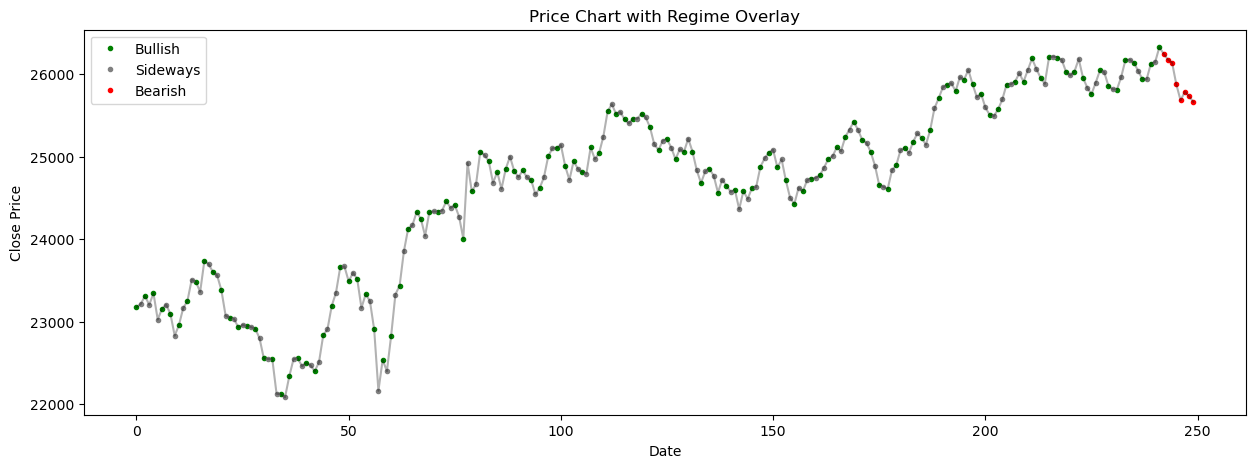

In [57]:
import matplotlib.pyplot as plt

colors = {'Bullish':'green', 'Bearish':'red', 'Sideways':'gray'}

plt.figure(figsize=(15,5))
for regime in df_hmm['Regime_Label'].unique():
    mask = df_hmm['Regime_Label'] == regime
    plt.plot(df_hmm.index[mask], df['Close_spot'].loc[df_hmm.index[mask]], '.', 
             color=colors[regime], label=regime)

plt.plot(df['Close_spot'], color='black', alpha=0.3)  # overall price line
plt.title('Price Chart with Regime Overlay')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



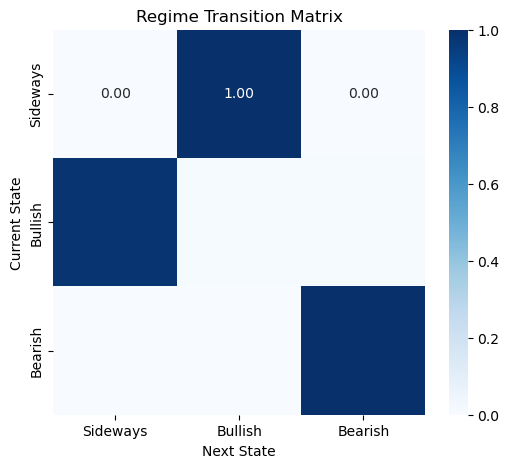

In [58]:
import seaborn as sns
import numpy as np

states = df_hmm['Regime'].values
n_regimes = len(np.unique(states))
transitions = np.zeros((n_regimes, n_regimes))

for (i,j) in zip(states[:-1], states[1:]):
    transitions[i,j] += 1

# Normalize rows to probabilities
transitions = transitions / transitions.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Blues', 
            xticklabels=state_map.values(), yticklabels=state_map.values())
plt.title('Regime Transition Matrix')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()


Regime Statistics:
              Average_IV                                    IV_Spread       \
                  count mean  std  min  25%  50%  75%  max     count mean   
Regime_Label                                                                
Bearish             8.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       8.0  0.0   
Bullish           122.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     122.0  0.0   
Sideways          120.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     120.0  0.0   

              ... Futures_Basis           Spot_Return                      \
              ...           75%       max       count      mean       std   
Regime_Label  ...                                                           
Bearish       ...      0.004070  0.004203         8.0 -0.003188  0.004234   
Bullish       ...      0.006131  0.009776       122.0  0.001145  0.006823   
Sideways      ...      0.006131  0.009422       120.0 -0.000098  0.007658   

                                                      

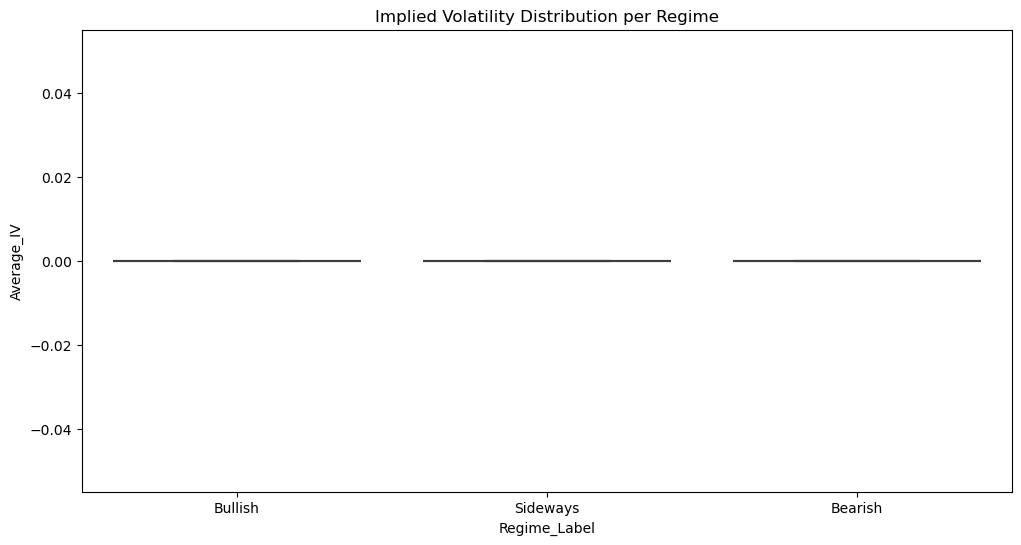

In [59]:
stats = df_hmm.groupby('Regime_Label')[hmm_features].describe()
print("Regime Statistics:\n", stats)

# Example: Boxplot for Implied Volatility
plt.figure(figsize=(12,6))
sns.boxplot(x='Regime_Label', y='Average_IV', data=df_hmm)
plt.title('Implied Volatility Distribution per Regime')
plt.show()


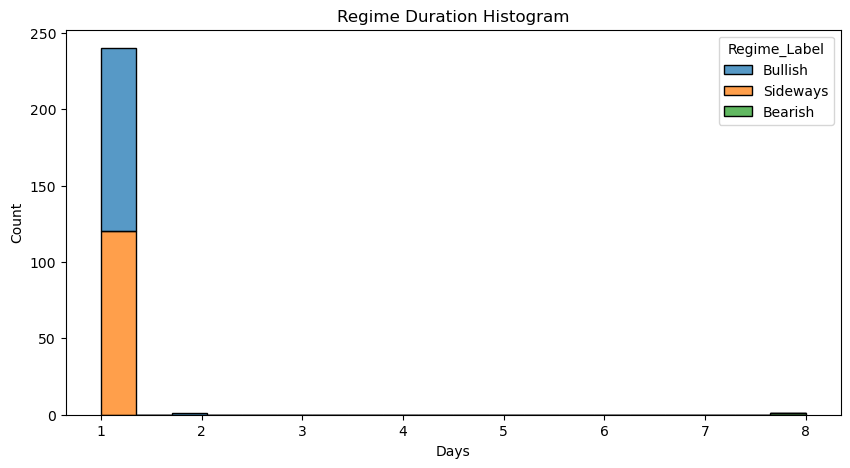

In [60]:
df_hmm['Regime_Change'] = (df_hmm['Regime_Label'] != df_hmm['Regime_Label'].shift(1)).astype(int)
df_hmm['Regime_ID'] = df_hmm['Regime_Change'].cumsum()

durations = df_hmm.groupby('Regime_ID').agg({'Regime_Label':'first', 'Spot_Return':'count'}).rename(columns={'Spot_Return':'Duration'})

plt.figure(figsize=(10,5))
sns.histplot(data=durations, x='Duration', hue='Regime_Label', multiple='stack', bins=20)
plt.title('Regime Duration Histogram')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()
